In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import pandas as pd
from PIL import Image, ImageDraw, ImageOps
import ast
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, LeakyReLU, Embedding, Concatenate, Reshape, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

In [3]:
# define 30 classes to load the data for
# categories = ['airplane']
# label_dict = {0:'airplane'}
categories = ['airplane','bee', 'bicycle', 'bird', 'butterfly','cake','camera','cat',
              'chair','clock','computer', 'diamond', 'door', 'ear', 'guitar', 
              'hamburger','hammer','hand','hat','ladder','leaf','lion','pencil',
              'rabbit','scissors','shoe','star','sword','The_Eiffel_Tower','tree']
label_dict = {0:'airplane',1:'bee', 2:'bicycle', 3:'bird', 4:'butterfly',5:'cake',6:'camera',7:'cat',
              8:'chair',9:'clock',10:'computer', 11:'diamond', 12:'door', 13:'ear', 14:'guitar', 
              15:'hamburger',16:'hammer',17:'hand',18:'hat',19:'ladder',20:'leaf',21:'lion',22:'pencil',
              23:'rabbit',24:'scissors',25:'shoe',26:'star',27:'sword',28:'The_Eiffel_Tower',29:'tree'}
inverse_label =  {v: k for k, v in label_dict.items()}
# load data for each category
classes = {}
for category in categories:
    data = pd.read_csv("input/" + category + ".csv")
    classes[category] = data

In [4]:
def convert_to_np_raw(drawing, width = 28, height = 28):
    """
    INPUT:
        drawing - drawing in initial format
        width - width of the initial image
        height - height of the initial image
    OUTPUT:
        img - drawing converted to the numpy array (width X height)
    """
    # initialize empty numpy array
    img = np.zeros((width, height))

    # create a PIL image out of drawing
    pil_img = convert_to_PIL(drawing)

    #resize to 28,28
    pil_img.thumbnail((width, height), Image.ANTIALIAS)

    pil_img = pil_img.convert('RGB')
    pixels = pil_img.load()

    # fill in numpy array with pixel values
    for i in range(0, width):
        for j in range(0, height):
            img[i, j] = 1 - pixels[j, i][0] / 255

    return img
def convert_to_PIL(drawing, width = 256, height = 256):
    """
    Function to convert from drawing to PIL image.
    INPUT:
        drawing - drawing from 'drawing' column
        width - width of the initial image
        height - height of the initial image
    OUTPUT:
        pil_img - (PIL Image) image
    """

    # initialize empty (white) PIL image
    pil_img = Image.new('RGB', (width, height), 'white')
    pixels = pil_img.load()

    draw = ImageDraw.Draw(pil_img)

    # draw strokes as lines
    for x,y in drawing:
        for i in range(1, len(x)):
            draw.line((x[i-1], y[i-1], x[i], y[i]), fill=0)

    return pil_img
    
def view_images_grid(X_train, y_train, label, label_name):
    """
    Function to plot grid with several examples of images with
    passed label.
    INPUT:
        X_train - (numpy array) training dataset
        y_train - (numpy array) labels for training dataset
        label - (int) label for images
        label_name - (str) name for images label
    OUTPUT: None
    """
    indices = np.where(y_train == label)
    X = pd.DataFrame(X_train)

    for label_num in range(0,50):
        plt.subplot(5,10, label_num+1) #create subplots
        image = X.iloc[indices[0][label_num]].as_matrix().reshape(28,28)  #reshape images
        plt.imshow(image) #plot the data
        plt.xticks([]) #removes numbered labels on x-axis
        plt.yticks([]) #removes numbered labels on y-axis
        plt.suptitle(label_name)

        plt.savefig(label_name + '_grid.png')

In [5]:
# create the dictionary containing classes names as keys and images as values
values_dict = {}
ground_truth = {}
for category in categories:
    data = classes[category][:2500]
    # values = [convert_to_np_raw(ast.literal_eval(img)).reshape(1, 784) for img in data['drawing'].values]
    # values = [ ast.literal_eval(img) for img in data['drawing'].values ]
    # values = [convert_to_np_raw(ast.literal_eval(img)) for img in data['drawing'].values]
    values = []
    y = []
    for img in data['drawing'].values:
        values.append(convert_to_np_raw(ast.literal_eval(img)))
        y.append(inverse_label[category])
    values_dict[category] = values
    ground_truth[category] = y

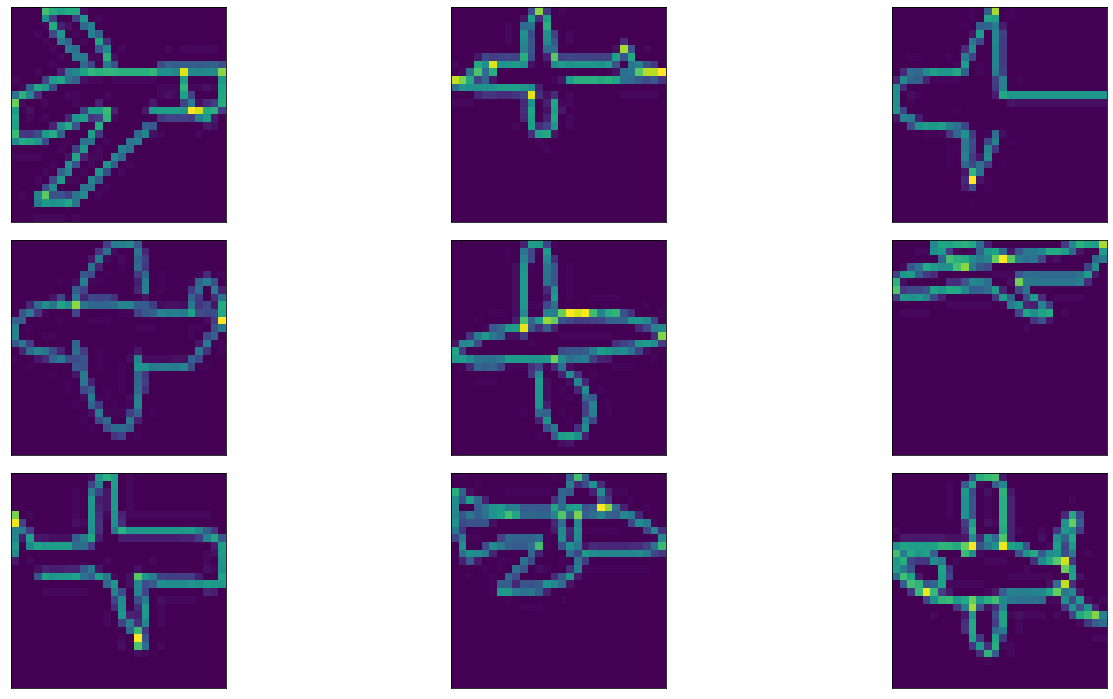

In [6]:
correct_figure = plt.figure()
correct_figure.set_size_inches(20, 10)

# image_transform =   transform=transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize(64),
#     transforms.ToTensor()
# ])

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    npimg = values_dict['airplane'][i]
    #npimg = image_transform(torch.Tensor(npimg))
    npimg = (npimg - np.min(npimg))/np.ptp(npimg)
    plt.imshow(npimg)
  # plt.imshow(np.transpose(npimg, (1, 2, 0)))
  # plt.title("Predicted: {}, GT: {}".format(classes[predicted[correct_label[i]]], classes[y_label[correct_label[i]]]))
    plt.xticks([])
    plt.yticks([])

In [7]:
X_train = np.empty([])
y_train = np.empty([])
# print(type(values_dict[category][5]))
for category in categories:
    if category == 'airplane':
        X_train = np.array(values_dict[category])
        y_train = np.array(ground_truth[category])
    if category != 'airplane':
        X_train = np.concatenate( (X_train, np.array(values_dict[category]) ), axis=0)
        y_train = np.concatenate( (y_train, np.array(ground_truth[category]) ), axis=0)
        #print(x_train)
#     for i in range(len(values_dict[category])):
#         print(values_dict[category][i])
#         x_train = np.vstack( x_train, values_dict[category][i] )
#         y_train = np.vstack( y_train, ground_truth[category][i] )
#         x_train = np.concatenate( x_train, values_dict[category][i] )
#         y_train = np.concatenate( y_train, ground_truth[category][i] )
#data_set = CustomTensorDataset(tensors=(feature_tensor, target_tensor), transform=image_transform)
# data_set = torch.utils.data.TensorDataset(feature_tensor, target_tensor.long(),image_transform)


In [8]:


def _discriminator(input_shape=(28, 28, 1), n_classes = len(categories)):
    # 1. y_label input
    y_label = Input(shape=(1,))
    # embedding y_label
    y_embedding = Embedding(n_classes, 50)(y_label)
    # cale up to image dimensions with linear activation
    n_shape = input_shape[0] * input_shape[1]
    li = Dense(n_shape)(y_embedding)
    li = Reshape((input_shape[0], input_shape[1], 1))(li)

    # 2. image input
    inpt_image = Input(shape=(28, 28, 1))

    # 3. concate y_label và image
    concat = Concatenate()([inpt_image, li])
    # 4. feature extractor thông qua CNN blocks:
    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(concat)
    fe = LeakyReLU(alpha=0.2)(fe)

    fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)

    # flatten output
    fe = Flatten()(fe)
    fe = Dropout(0.4)(fe)
    out_layer = Dense(1, activation='sigmoid')(fe)

    # model
    model = Model([inpt_image, y_label], out_layer)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [9]:
import keras.utils.vis_utils
from importlib import reload
reload(keras.utils.vis_utils)

from tensorflow.keras.utils import plot_model

discriminator = _discriminator(input_shape=(28, 28, 1), n_classes=30)
plot_model(discriminator)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [10]:
def _generator(latent_dim=100, n_classes=len(categories)):
    # 1. y_label input
    y_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(y_label)
    n_shape = 7 * 7
    li = Dense(n_shape)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)

    # 2. input noise vector x
    in_lat = Input(shape=(latent_dim,))
    n_shape = 128 * 7 * 7
    gen = Dense(n_shape)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    # foundation for 7x7 image
    gen = Reshape((7, 7, 128))(gen)

    # 3. merge image gen and label input
    merge = Concatenate()([gen, li])

    # 4. Conv2DTranspose to upsample
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)

    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    # model
    model = Model([in_lat, y_label], out_layer)
    return model

generator = _generator(latent_dim=100, n_classes=len(categories))
plot_model(generator)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [11]:
def _cGAN(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

cGAN_model = _cGAN(generator, discriminator)
plot_model(cGAN_model)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [12]:
# standardize training data
def _standardize_data(X_train, y_train):
    X = np.expand_dims(X_train, axis=-1)
    X = X.astype('float32')
    # standardize to the range [-1, 1]
    X = (X - 127.5) / 127.5
    return [X, y_train]

In [13]:
# select real samples
def _generate_real_samples(dataset, n_samples):
    images, labels = dataset
    # choose n_samples instances
    ix = np.random.randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    return [X, labels], y

In [14]:
# generate points in latent space as input for the generator
def _generate_latent_points(latent_dim, n_samples, n_classes=len(categories)):
    # generate points in the latent space
    x_input = np.random.randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = np.random.randint(0, n_classes, n_samples)
    return [z_input, labels]
 
# use the generator to generate n fake examples, with class labels
def _generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = _generate_latent_points(latent_dim, n_samples)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = np.zeros((n_samples, 1))
    return [images, labels_input], y

In [15]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = _generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = _generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
  

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist):
    # plot loss
    plt.subplot(2, 1, 1)
    plt.plot(d1_hist, label='d-real')
    plt.plot(d2_hist, label='d-fake')
    plt.plot(g_hist, label='gen')
    plt.legend()
    # plot discriminator accuracy
    plt.subplot(2, 1, 2)
    plt.plot(a1_hist, label='acc-real')
    plt.plot(a2_hist, label='acc-fake')
    plt.legend()
    # save plot to file
    plt.savefig('plot_line_plot_loss.png')
    plt.show()

In [16]:
def _train(g_model, d_model, cGAN_model, dataset, latent_dim, n_epochs, n_batch=128, save_every_epochs=50):
    '''
    g_model: generator model
    d_model: discriminator model
    cGAN_model: gan_model
    dataset: training set (X_train, y_train)
    latent_dim: # dimensions of latent space
    n_epochs: # epochs
    n_batch: batch size
    save_every_epochs: save model after a certain number of epochs
    '''
    # Calculate # batch per epoch
    # batch_per_epoch = int(dataset[0].shape[0] / n_batch)
    batch_per_epoch = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # prepare lists for storing stats each iteration
    d1_hist, d2_hist, g_hist, a1_hist, a2_hist = list(), list(), list(), list(), list()
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(batch_per_epoch):
            # 1. train discrinator
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = _generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, d_acc1 = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = _generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, d_acc2 = d_model.train_on_batch([X_fake, labels], y_fake)
            # 2. train generator
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = _generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples to fool discriminator so label is 1.
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator's error 
            g_loss = cGAN_model.train_on_batch([z_input, labels_input], y_gan)
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
                (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
            # record history
            d1_hist.append(d_loss1)
            d2_hist.append(d_loss2)
            g_hist.append(g_loss)
            a1_hist.append(d_acc1)
            a2_hist.append(d_acc2)
    # evaluate the model performance, sometimes
        if (i+1) % 10 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
        if (i % save_every_epochs ==0) & (i > 0):
            g_model.save('cGAN_generator_epoch{}.h5'.format(i))
            
    plot_history(d1_hist, d2_hist, g_hist, a1_hist, a2_hist)
    # save the generator model
    g_model.save('cGAN_generator.h5')

In [17]:
# dataset = tf.data.Dataset.from_tensor_slices((x_train,y_train))
# dataset = dataset.shuffle(len(dataset))
# BATCH_SIZE = 64
# SHUFFLE_BUFFER_SIZE = 100
# train_size = int(len(dataset)*.9)
# train_dataset = dataset.take(train_size)
# test_dataset = dataset.skip(len(dataset) - train_size)

# train_dataset = train_dataset.shuffle(train_size).batch(BATCH_SIZE)
# test_dataset = test_dataset.shuffle(len(dataset) - train_size).batch(BATCH_SIZE)


print('Train shape: ', X_train.shape, y_train.shape)
#print('Test shape : ', X_test.shape, y_test.shape)

Train shape:  (75000, 28, 28) (75000,)


In [18]:
# i=0
# for element in dataset:
#     x, y = element
#     print(y)
#     i+=1
#     break
# print(i)

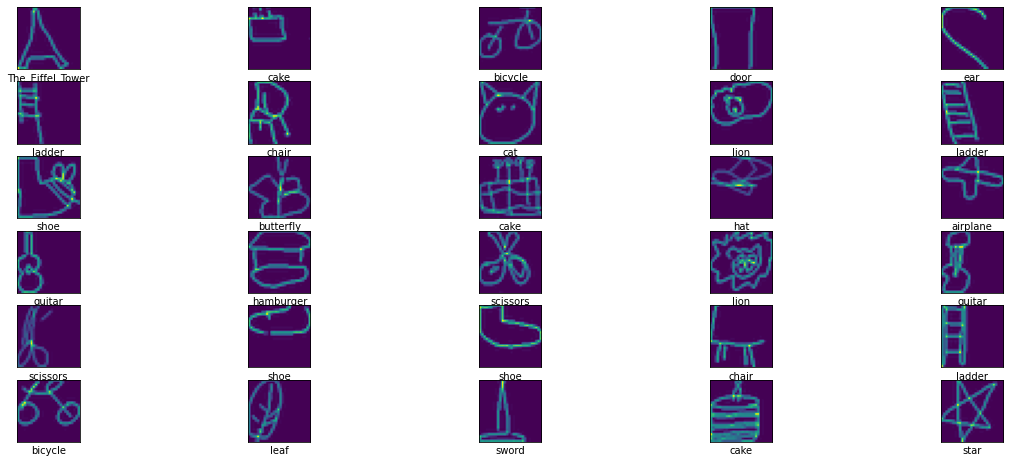

In [19]:
import matplotlib.pyplot as plt
import numpy as np


class_names = {0:'airplane',1:'bee', 2:'bicycle', 3:'bird', 4:'butterfly',5:'cake',6:'camera',7:'cat',
              8:'chair',9:'clock',10:'computer', 11:'diamond', 12:'door', 13:'ear', 14:'guitar', 
              15:'hamburger',16:'hammer',17:'hand',18:'hat',19:'ladder',20:'leaf',21:'lion',22:'pencil',
              23:'rabbit',24:'scissors',25:'shoe',26:'star',27:'sword',28:'The_Eiffel_Tower',29:'tree'}

idxs = np.arange(X_train.shape[0])
plt.figure(figsize=(20, 8))
for i, idx in enumerate(np.random.choice(idxs, len(class_names))):
    plt.subplot(6, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[idx])
    #plt.imshow(X_train[idx], cmap='gray_r') # gray pictures
    plt.xlabel(class_names[y_train[idx]])
plt.show()

In [20]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# print(physical_devices)
# if physical_devices:
#       tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [21]:
# Epochs
n_epochs = 500
# latent space
latent_dim = 100
# discriminator
d_model = _discriminator()
# generator
g_model = _generator(latent_dim)
# cGAN
cGAN_model = _cGAN(g_model, d_model)
# load image data
dataset = _standardize_data(X_train, y_train)
# train model
_train(g_model, d_model, cGAN_model, dataset, latent_dim, n_epochs=n_epochs)

>1, 1/585, d1=0.673, d2=0.694 g=0.693
>1, 2/585, d1=0.582, d2=0.698 g=0.689
>1, 3/585, d1=0.505, d2=0.707 g=0.679
>1, 4/585, d1=0.439, d2=0.725 g=0.661
>1, 5/585, d1=0.365, d2=0.754 g=0.634
>1, 6/585, d1=0.309, d2=0.805 g=0.594
>1, 7/585, d1=0.273, d2=0.881 g=0.546
>1, 8/585, d1=0.244, d2=0.974 g=0.495
>1, 9/585, d1=0.244, d2=1.071 g=0.456
>1, 10/585, d1=0.256, d2=1.124 g=0.443
>1, 11/585, d1=0.294, d2=1.121 g=0.452
>1, 12/585, d1=0.345, d2=1.079 g=0.475
>1, 13/585, d1=0.392, d2=1.026 g=0.509
>1, 14/585, d1=0.444, d2=0.950 g=0.541
>1, 15/585, d1=0.489, d2=0.908 g=0.577
>1, 16/585, d1=0.526, d2=0.870 g=0.594
>1, 17/585, d1=0.565, d2=0.851 g=0.614
>1, 18/585, d1=0.590, d2=0.820 g=0.627
>1, 19/585, d1=0.605, d2=0.801 g=0.638
>1, 20/585, d1=0.623, d2=0.780 g=0.650
>1, 21/585, d1=0.638, d2=0.772 g=0.656
>1, 22/585, d1=0.644, d2=0.771 g=0.669
>1, 23/585, d1=0.651, d2=0.751 g=0.670
>1, 24/585, d1=0.667, d2=0.736 g=0.677
>1, 25/585, d1=0.664, d2=0.746 g=0.678
>1, 26/585, d1=0.670, d2=0.748 g=0

>1, 209/585, d1=0.698, d2=0.696 g=0.695
>1, 210/585, d1=0.696, d2=0.701 g=0.695
>1, 211/585, d1=0.693, d2=0.697 g=0.697
>1, 212/585, d1=0.695, d2=0.694 g=0.695
>1, 213/585, d1=0.695, d2=0.696 g=0.695
>1, 214/585, d1=0.697, d2=0.699 g=0.695
>1, 215/585, d1=0.693, d2=0.701 g=0.695
>1, 216/585, d1=0.695, d2=0.701 g=0.695
>1, 217/585, d1=0.697, d2=0.698 g=0.695
>1, 218/585, d1=0.697, d2=0.698 g=0.696
>1, 219/585, d1=0.694, d2=0.700 g=0.695
>1, 220/585, d1=0.694, d2=0.700 g=0.694
>1, 221/585, d1=0.693, d2=0.701 g=0.693
>1, 222/585, d1=0.693, d2=0.695 g=0.692
>1, 223/585, d1=0.693, d2=0.700 g=0.695
>1, 224/585, d1=0.697, d2=0.698 g=0.695
>1, 225/585, d1=0.693, d2=0.699 g=0.693
>1, 226/585, d1=0.693, d2=0.699 g=0.692
>1, 227/585, d1=0.693, d2=0.697 g=0.692
>1, 228/585, d1=0.693, d2=0.701 g=0.693
>1, 229/585, d1=0.693, d2=0.700 g=0.695
>1, 230/585, d1=0.693, d2=0.701 g=0.692
>1, 231/585, d1=0.690, d2=0.702 g=0.692
>1, 232/585, d1=0.694, d2=0.699 g=0.692
>1, 233/585, d1=0.695, d2=0.700 g=0.695


>1, 414/585, d1=0.691, d2=0.697 g=0.692
>1, 415/585, d1=0.693, d2=0.697 g=0.693
>1, 416/585, d1=0.693, d2=0.696 g=0.693
>1, 417/585, d1=0.691, d2=0.697 g=0.692
>1, 418/585, d1=0.693, d2=0.696 g=0.691
>1, 419/585, d1=0.692, d2=0.699 g=0.692
>1, 420/585, d1=0.693, d2=0.697 g=0.692
>1, 421/585, d1=0.691, d2=0.697 g=0.691
>1, 422/585, d1=0.691, d2=0.699 g=0.691
>1, 423/585, d1=0.691, d2=0.700 g=0.691
>1, 424/585, d1=0.691, d2=0.697 g=0.691
>1, 425/585, d1=0.691, d2=0.699 g=0.692
>1, 426/585, d1=0.692, d2=0.699 g=0.691
>1, 427/585, d1=0.691, d2=0.699 g=0.691
>1, 428/585, d1=0.691, d2=0.698 g=0.692
>1, 429/585, d1=0.691, d2=0.698 g=0.691
>1, 430/585, d1=0.691, d2=0.697 g=0.692
>1, 431/585, d1=0.692, d2=0.700 g=0.692
>1, 432/585, d1=0.692, d2=0.698 g=0.692
>1, 433/585, d1=0.692, d2=0.697 g=0.692
>1, 434/585, d1=0.693, d2=0.696 g=0.691
>1, 435/585, d1=0.691, d2=0.697 g=0.693
>1, 436/585, d1=0.692, d2=0.697 g=0.692
>1, 437/585, d1=0.690, d2=0.698 g=0.691
>1, 438/585, d1=0.691, d2=0.698 g=0.692


>2, 35/585, d1=0.694, d2=0.696 g=0.693
>2, 36/585, d1=0.692, d2=0.695 g=0.694
>2, 37/585, d1=0.694, d2=0.695 g=0.693
>2, 38/585, d1=0.693, d2=0.695 g=0.693
>2, 39/585, d1=0.693, d2=0.696 g=0.694
>2, 40/585, d1=0.694, d2=0.694 g=0.693
>2, 41/585, d1=0.693, d2=0.695 g=0.692
>2, 42/585, d1=0.693, d2=0.696 g=0.693
>2, 43/585, d1=0.693, d2=0.696 g=0.693
>2, 44/585, d1=0.693, d2=0.695 g=0.693
>2, 45/585, d1=0.693, d2=0.696 g=0.692
>2, 46/585, d1=0.693, d2=0.696 g=0.692
>2, 47/585, d1=0.692, d2=0.694 g=0.694
>2, 48/585, d1=0.693, d2=0.695 g=0.692
>2, 49/585, d1=0.693, d2=0.695 g=0.692
>2, 50/585, d1=0.693, d2=0.696 g=0.693
>2, 51/585, d1=0.693, d2=0.695 g=0.692
>2, 52/585, d1=0.693, d2=0.695 g=0.693
>2, 53/585, d1=0.693, d2=0.697 g=0.693
>2, 54/585, d1=0.692, d2=0.696 g=0.693
>2, 55/585, d1=0.692, d2=0.695 g=0.693
>2, 56/585, d1=0.693, d2=0.695 g=0.693
>2, 57/585, d1=0.693, d2=0.695 g=0.693
>2, 58/585, d1=0.693, d2=0.694 g=0.693
>2, 59/585, d1=0.692, d2=0.696 g=0.693
>2, 60/585, d1=0.694, d2=

>2, 242/585, d1=0.694, d2=0.694 g=0.693
>2, 243/585, d1=0.694, d2=0.695 g=0.693
>2, 244/585, d1=0.693, d2=0.695 g=0.694
>2, 245/585, d1=0.694, d2=0.694 g=0.693
>2, 246/585, d1=0.694, d2=0.693 g=0.693
>2, 247/585, d1=0.693, d2=0.694 g=0.693
>2, 248/585, d1=0.693, d2=0.695 g=0.693
>2, 249/585, d1=0.695, d2=0.693 g=0.694
>2, 250/585, d1=0.695, d2=0.695 g=0.693
>2, 251/585, d1=0.693, d2=0.695 g=0.693
>2, 252/585, d1=0.694, d2=0.695 g=0.693
>2, 253/585, d1=0.694, d2=0.695 g=0.693
>2, 254/585, d1=0.693, d2=0.694 g=0.693
>2, 255/585, d1=0.694, d2=0.694 g=0.693
>2, 256/585, d1=0.693, d2=0.694 g=0.694
>2, 257/585, d1=0.693, d2=0.695 g=0.694
>2, 258/585, d1=0.693, d2=0.695 g=0.693
>2, 259/585, d1=0.693, d2=0.695 g=0.693
>2, 260/585, d1=0.693, d2=0.694 g=0.693
>2, 261/585, d1=0.693, d2=0.694 g=0.693
>2, 262/585, d1=0.693, d2=0.695 g=0.693
>2, 263/585, d1=0.693, d2=0.695 g=0.693
>2, 264/585, d1=0.694, d2=0.694 g=0.693
>2, 265/585, d1=0.693, d2=0.694 g=0.693
>2, 266/585, d1=0.693, d2=0.695 g=0.693


>2, 447/585, d1=0.694, d2=0.694 g=0.694
>2, 448/585, d1=0.694, d2=0.694 g=0.694
>2, 449/585, d1=0.694, d2=0.693 g=0.693
>2, 450/585, d1=0.694, d2=0.696 g=0.693
>2, 451/585, d1=0.694, d2=0.693 g=0.694
>2, 452/585, d1=0.693, d2=0.693 g=0.694
>2, 453/585, d1=0.694, d2=0.694 g=0.693
>2, 454/585, d1=0.694, d2=0.694 g=0.694
>2, 455/585, d1=0.694, d2=0.693 g=0.694
>2, 456/585, d1=0.693, d2=0.694 g=0.694
>2, 457/585, d1=0.694, d2=0.694 g=0.693
>2, 458/585, d1=0.693, d2=0.694 g=0.693
>2, 459/585, d1=0.694, d2=0.694 g=0.694
>2, 460/585, d1=0.694, d2=0.694 g=0.694
>2, 461/585, d1=0.693, d2=0.695 g=0.694
>2, 462/585, d1=0.694, d2=0.694 g=0.695
>2, 463/585, d1=0.694, d2=0.693 g=0.694
>2, 464/585, d1=0.694, d2=0.695 g=0.694
>2, 465/585, d1=0.694, d2=0.694 g=0.693
>2, 466/585, d1=0.694, d2=0.694 g=0.693
>2, 467/585, d1=0.694, d2=0.694 g=0.694
>2, 468/585, d1=0.694, d2=0.694 g=0.694
>2, 469/585, d1=0.694, d2=0.694 g=0.694
>2, 470/585, d1=0.693, d2=0.694 g=0.694
>2, 471/585, d1=0.693, d2=0.694 g=0.694


>3, 69/585, d1=0.694, d2=0.693 g=0.694
>3, 70/585, d1=0.694, d2=0.694 g=0.694
>3, 71/585, d1=0.693, d2=0.693 g=0.694
>3, 72/585, d1=0.694, d2=0.694 g=0.694
>3, 73/585, d1=0.694, d2=0.694 g=0.694
>3, 74/585, d1=0.694, d2=0.694 g=0.694
>3, 75/585, d1=0.694, d2=0.694 g=0.694
>3, 76/585, d1=0.694, d2=0.694 g=0.694
>3, 77/585, d1=0.694, d2=0.693 g=0.693
>3, 78/585, d1=0.694, d2=0.693 g=0.694
>3, 79/585, d1=0.694, d2=0.694 g=0.694
>3, 80/585, d1=0.694, d2=0.693 g=0.694
>3, 81/585, d1=0.695, d2=0.694 g=0.694
>3, 82/585, d1=0.693, d2=0.694 g=0.693
>3, 83/585, d1=0.693, d2=0.694 g=0.694
>3, 84/585, d1=0.694, d2=0.693 g=0.694
>3, 85/585, d1=0.694, d2=0.693 g=0.694
>3, 86/585, d1=0.694, d2=0.694 g=0.694
>3, 87/585, d1=0.694, d2=0.693 g=0.694
>3, 88/585, d1=0.694, d2=0.694 g=0.693
>3, 89/585, d1=0.694, d2=0.693 g=0.694
>3, 90/585, d1=0.693, d2=0.694 g=0.694
>3, 91/585, d1=0.693, d2=0.693 g=0.694
>3, 92/585, d1=0.694, d2=0.694 g=0.694
>3, 93/585, d1=0.694, d2=0.694 g=0.693
>3, 94/585, d1=0.694, d2=

>3, 275/585, d1=0.693, d2=0.694 g=0.693
>3, 276/585, d1=0.694, d2=0.694 g=0.693
>3, 277/585, d1=0.694, d2=0.694 g=0.693
>3, 278/585, d1=0.693, d2=0.694 g=0.694
>3, 279/585, d1=0.693, d2=0.694 g=0.694
>3, 280/585, d1=0.694, d2=0.694 g=0.693
>3, 281/585, d1=0.693, d2=0.694 g=0.693
>3, 282/585, d1=0.693, d2=0.694 g=0.693
>3, 283/585, d1=0.693, d2=0.693 g=0.694
>3, 284/585, d1=0.694, d2=0.694 g=0.694
>3, 285/585, d1=0.694, d2=0.694 g=0.693
>3, 286/585, d1=0.694, d2=0.693 g=0.694
>3, 287/585, d1=0.694, d2=0.693 g=0.694
>3, 288/585, d1=0.693, d2=0.694 g=0.694
>3, 289/585, d1=0.694, d2=0.694 g=0.694
>3, 290/585, d1=0.694, d2=0.694 g=0.694
>3, 291/585, d1=0.694, d2=0.693 g=0.694
>3, 292/585, d1=0.694, d2=0.693 g=0.693
>3, 293/585, d1=0.694, d2=0.694 g=0.694
>3, 294/585, d1=0.694, d2=0.693 g=0.694
>3, 295/585, d1=0.694, d2=0.694 g=0.694
>3, 296/585, d1=0.694, d2=0.694 g=0.694
>3, 297/585, d1=0.694, d2=0.693 g=0.694
>3, 298/585, d1=0.694, d2=0.693 g=0.694
>3, 299/585, d1=0.694, d2=0.693 g=0.695


>3, 480/585, d1=0.694, d2=0.694 g=0.694
>3, 481/585, d1=0.694, d2=0.693 g=0.694
>3, 482/585, d1=0.694, d2=0.693 g=0.694
>3, 483/585, d1=0.694, d2=0.693 g=0.694
>3, 484/585, d1=0.694, d2=0.693 g=0.694
>3, 485/585, d1=0.695, d2=0.692 g=0.694
>3, 486/585, d1=0.694, d2=0.694 g=0.694
>3, 487/585, d1=0.694, d2=0.694 g=0.694
>3, 488/585, d1=0.694, d2=0.694 g=0.694
>3, 489/585, d1=0.694, d2=0.693 g=0.694
>3, 490/585, d1=0.694, d2=0.693 g=0.694
>3, 491/585, d1=0.694, d2=0.693 g=0.694
>3, 492/585, d1=0.694, d2=0.693 g=0.694
>3, 493/585, d1=0.694, d2=0.693 g=0.694
>3, 494/585, d1=0.694, d2=0.694 g=0.694
>3, 495/585, d1=0.694, d2=0.693 g=0.694
>3, 496/585, d1=0.694, d2=0.693 g=0.694
>3, 497/585, d1=0.694, d2=0.693 g=0.694
>3, 498/585, d1=0.694, d2=0.693 g=0.694
>3, 499/585, d1=0.695, d2=0.693 g=0.694
>3, 500/585, d1=0.694, d2=0.693 g=0.694
>3, 501/585, d1=0.694, d2=0.693 g=0.694
>3, 502/585, d1=0.694, d2=0.693 g=0.694
>3, 503/585, d1=0.694, d2=0.694 g=0.694
>3, 504/585, d1=0.694, d2=0.693 g=0.694


>4, 103/585, d1=0.695, d2=0.693 g=0.694
>4, 104/585, d1=0.694, d2=0.693 g=0.694
>4, 105/585, d1=0.695, d2=0.693 g=0.694
>4, 106/585, d1=0.694, d2=0.693 g=0.695
>4, 107/585, d1=0.694, d2=0.693 g=0.694
>4, 108/585, d1=0.695, d2=0.693 g=0.694
>4, 109/585, d1=0.694, d2=0.693 g=0.694
>4, 110/585, d1=0.695, d2=0.693 g=0.694
>4, 111/585, d1=0.694, d2=0.693 g=0.694
>4, 112/585, d1=0.693, d2=0.693 g=0.694
>4, 113/585, d1=0.694, d2=0.693 g=0.694
>4, 114/585, d1=0.695, d2=0.693 g=0.695
>4, 115/585, d1=0.695, d2=0.693 g=0.694
>4, 116/585, d1=0.694, d2=0.692 g=0.694
>4, 117/585, d1=0.694, d2=0.693 g=0.694
>4, 118/585, d1=0.694, d2=0.693 g=0.694
>4, 119/585, d1=0.694, d2=0.694 g=0.694
>4, 120/585, d1=0.694, d2=0.693 g=0.694
>4, 121/585, d1=0.694, d2=0.693 g=0.694
>4, 122/585, d1=0.694, d2=0.693 g=0.694
>4, 123/585, d1=0.694, d2=0.693 g=0.694
>4, 124/585, d1=0.695, d2=0.693 g=0.694
>4, 125/585, d1=0.695, d2=0.693 g=0.695
>4, 126/585, d1=0.694, d2=0.692 g=0.694
>4, 127/585, d1=0.694, d2=0.693 g=0.694


>4, 308/585, d1=0.694, d2=0.693 g=0.694
>4, 309/585, d1=0.694, d2=0.692 g=0.695
>4, 310/585, d1=0.694, d2=0.693 g=0.694
>4, 311/585, d1=0.694, d2=0.693 g=0.694
>4, 312/585, d1=0.694, d2=0.692 g=0.695
>4, 313/585, d1=0.694, d2=0.693 g=0.694
>4, 314/585, d1=0.694, d2=0.692 g=0.694
>4, 315/585, d1=0.695, d2=0.693 g=0.694
>4, 316/585, d1=0.694, d2=0.693 g=0.694
>4, 317/585, d1=0.694, d2=0.693 g=0.695
>4, 318/585, d1=0.695, d2=0.692 g=0.694
>4, 319/585, d1=0.694, d2=0.692 g=0.694
>4, 320/585, d1=0.694, d2=0.693 g=0.694
>4, 321/585, d1=0.695, d2=0.692 g=0.694
>4, 322/585, d1=0.695, d2=0.693 g=0.695
>4, 323/585, d1=0.695, d2=0.693 g=0.694
>4, 324/585, d1=0.695, d2=0.693 g=0.694
>4, 325/585, d1=0.695, d2=0.693 g=0.694
>4, 326/585, d1=0.695, d2=0.693 g=0.694
>4, 327/585, d1=0.694, d2=0.693 g=0.694
>4, 328/585, d1=0.694, d2=0.693 g=0.694
>4, 329/585, d1=0.694, d2=0.693 g=0.694
>4, 330/585, d1=0.694, d2=0.694 g=0.694
>4, 331/585, d1=0.695, d2=0.693 g=0.695
>4, 332/585, d1=0.694, d2=0.693 g=0.694


>4, 513/585, d1=0.694, d2=0.692 g=0.694
>4, 514/585, d1=0.695, d2=0.693 g=0.694
>4, 515/585, d1=0.694, d2=0.693 g=0.694
>4, 516/585, d1=0.694, d2=0.693 g=0.694
>4, 517/585, d1=0.694, d2=0.693 g=0.694
>4, 518/585, d1=0.694, d2=0.692 g=0.694
>4, 519/585, d1=0.694, d2=0.693 g=0.694
>4, 520/585, d1=0.694, d2=0.692 g=0.694
>4, 521/585, d1=0.694, d2=0.693 g=0.694
>4, 522/585, d1=0.694, d2=0.693 g=0.694
>4, 523/585, d1=0.694, d2=0.693 g=0.694
>4, 524/585, d1=0.694, d2=0.693 g=0.694
>4, 525/585, d1=0.695, d2=0.693 g=0.694
>4, 526/585, d1=0.694, d2=0.692 g=0.694
>4, 527/585, d1=0.694, d2=0.693 g=0.694
>4, 528/585, d1=0.694, d2=0.693 g=0.694
>4, 529/585, d1=0.694, d2=0.692 g=0.695
>4, 530/585, d1=0.694, d2=0.692 g=0.694
>4, 531/585, d1=0.694, d2=0.693 g=0.694
>4, 532/585, d1=0.694, d2=0.693 g=0.694
>4, 533/585, d1=0.694, d2=0.693 g=0.694
>4, 534/585, d1=0.694, d2=0.693 g=0.694
>4, 535/585, d1=0.694, d2=0.693 g=0.694
>4, 536/585, d1=0.695, d2=0.693 g=0.694
>4, 537/585, d1=0.694, d2=0.693 g=0.694


>5, 136/585, d1=0.694, d2=0.693 g=0.694
>5, 137/585, d1=0.694, d2=0.693 g=0.694
>5, 138/585, d1=0.694, d2=0.693 g=0.694
>5, 139/585, d1=0.694, d2=0.692 g=0.694
>5, 140/585, d1=0.694, d2=0.693 g=0.694
>5, 141/585, d1=0.694, d2=0.693 g=0.694
>5, 142/585, d1=0.694, d2=0.693 g=0.695
>5, 143/585, d1=0.694, d2=0.693 g=0.694
>5, 144/585, d1=0.694, d2=0.693 g=0.694
>5, 145/585, d1=0.694, d2=0.693 g=0.694
>5, 146/585, d1=0.695, d2=0.693 g=0.694
>5, 147/585, d1=0.695, d2=0.693 g=0.694
>5, 148/585, d1=0.694, d2=0.693 g=0.694
>5, 149/585, d1=0.694, d2=0.693 g=0.694
>5, 150/585, d1=0.694, d2=0.693 g=0.694
>5, 151/585, d1=0.694, d2=0.693 g=0.694
>5, 152/585, d1=0.694, d2=0.693 g=0.694
>5, 153/585, d1=0.694, d2=0.693 g=0.694
>5, 154/585, d1=0.694, d2=0.693 g=0.694
>5, 155/585, d1=0.694, d2=0.693 g=0.694
>5, 156/585, d1=0.694, d2=0.693 g=0.694
>5, 157/585, d1=0.694, d2=0.693 g=0.694
>5, 158/585, d1=0.694, d2=0.693 g=0.694
>5, 159/585, d1=0.694, d2=0.693 g=0.694
>5, 160/585, d1=0.694, d2=0.693 g=0.694


>5, 341/585, d1=0.694, d2=0.692 g=0.694
>5, 342/585, d1=0.695, d2=0.692 g=0.694
>5, 343/585, d1=0.694, d2=0.692 g=0.694
>5, 344/585, d1=0.694, d2=0.692 g=0.694
>5, 345/585, d1=0.694, d2=0.692 g=0.694
>5, 346/585, d1=0.694, d2=0.692 g=0.694
>5, 347/585, d1=0.694, d2=0.692 g=0.694
>5, 348/585, d1=0.694, d2=0.693 g=0.694
>5, 349/585, d1=0.694, d2=0.692 g=0.694
>5, 350/585, d1=0.694, d2=0.693 g=0.694
>5, 351/585, d1=0.694, d2=0.693 g=0.694
>5, 352/585, d1=0.694, d2=0.693 g=0.694
>5, 353/585, d1=0.694, d2=0.692 g=0.694
>5, 354/585, d1=0.694, d2=0.692 g=0.695
>5, 355/585, d1=0.694, d2=0.692 g=0.694
>5, 356/585, d1=0.695, d2=0.692 g=0.695
>5, 357/585, d1=0.694, d2=0.693 g=0.695
>5, 358/585, d1=0.695, d2=0.693 g=0.695
>5, 359/585, d1=0.695, d2=0.693 g=0.694
>5, 360/585, d1=0.694, d2=0.693 g=0.694
>5, 361/585, d1=0.694, d2=0.692 g=0.694
>5, 362/585, d1=0.695, d2=0.692 g=0.695
>5, 363/585, d1=0.694, d2=0.693 g=0.695
>5, 364/585, d1=0.694, d2=0.693 g=0.694
>5, 365/585, d1=0.695, d2=0.692 g=0.694


>5, 546/585, d1=0.694, d2=0.692 g=0.694
>5, 547/585, d1=0.694, d2=0.692 g=0.694
>5, 548/585, d1=0.694, d2=0.693 g=0.694
>5, 549/585, d1=0.694, d2=0.693 g=0.694
>5, 550/585, d1=0.694, d2=0.693 g=0.694
>5, 551/585, d1=0.694, d2=0.693 g=0.694
>5, 552/585, d1=0.694, d2=0.692 g=0.694
>5, 553/585, d1=0.694, d2=0.693 g=0.694
>5, 554/585, d1=0.694, d2=0.693 g=0.694
>5, 555/585, d1=0.694, d2=0.693 g=0.694
>5, 556/585, d1=0.694, d2=0.693 g=0.694
>5, 557/585, d1=0.694, d2=0.692 g=0.694
>5, 558/585, d1=0.694, d2=0.693 g=0.694
>5, 559/585, d1=0.694, d2=0.692 g=0.694
>5, 560/585, d1=0.694, d2=0.692 g=0.694
>5, 561/585, d1=0.694, d2=0.693 g=0.694
>5, 562/585, d1=0.694, d2=0.693 g=0.694
>5, 563/585, d1=0.694, d2=0.692 g=0.694
>5, 564/585, d1=0.694, d2=0.693 g=0.694
>5, 565/585, d1=0.694, d2=0.692 g=0.694
>5, 566/585, d1=0.694, d2=0.692 g=0.694
>5, 567/585, d1=0.694, d2=0.692 g=0.694
>5, 568/585, d1=0.694, d2=0.692 g=0.694
>5, 569/585, d1=0.695, d2=0.693 g=0.694
>5, 570/585, d1=0.694, d2=0.692 g=0.694


>6, 169/585, d1=0.695, d2=0.692 g=0.694
>6, 170/585, d1=0.694, d2=0.692 g=0.694
>6, 171/585, d1=0.694, d2=0.692 g=0.694
>6, 172/585, d1=0.694, d2=0.692 g=0.694
>6, 173/585, d1=0.694, d2=0.692 g=0.695
>6, 174/585, d1=0.694, d2=0.692 g=0.694
>6, 175/585, d1=0.694, d2=0.692 g=0.694
>6, 176/585, d1=0.694, d2=0.693 g=0.694
>6, 177/585, d1=0.694, d2=0.693 g=0.694
>6, 178/585, d1=0.694, d2=0.693 g=0.694
>6, 179/585, d1=0.694, d2=0.693 g=0.695
>6, 180/585, d1=0.694, d2=0.693 g=0.694
>6, 181/585, d1=0.694, d2=0.693 g=0.694
>6, 182/585, d1=0.694, d2=0.693 g=0.694
>6, 183/585, d1=0.694, d2=0.692 g=0.694
>6, 184/585, d1=0.694, d2=0.693 g=0.694
>6, 185/585, d1=0.694, d2=0.693 g=0.694
>6, 186/585, d1=0.694, d2=0.693 g=0.694
>6, 187/585, d1=0.694, d2=0.692 g=0.694
>6, 188/585, d1=0.694, d2=0.693 g=0.694
>6, 189/585, d1=0.694, d2=0.693 g=0.694
>6, 190/585, d1=0.694, d2=0.692 g=0.694
>6, 191/585, d1=0.694, d2=0.692 g=0.694
>6, 192/585, d1=0.694, d2=0.692 g=0.694
>6, 193/585, d1=0.694, d2=0.692 g=0.694


KeyboardInterrupt: 

In [ ]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=len(categories)):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('cGAN_generator.h5',compile=False)
# generate images
latent_points, labels = generate_latent_points(100, 100)
print(labels)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)



In [ ]:
[X_fake, labels], y_fake = _generate_fake_samples(model, latent_dim, 64)

In [ ]:
print(labels)

In [ ]:
correct_figure = plt.figure()
correct_figure.set_size_inches(20, 10)

# image_transform =   transform=transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize(64),
#     transforms.ToTensor()
# ])

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    npimg = X_fake[i]
    #npimg = image_transform(torch.Tensor(npimg))
    npimg = (npimg - np.min(npimg))/np.ptp(npimg)
    plt.imshow(npimg)
  # plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title("Label: {}".format(categories[labels[i]]))
    plt.xticks([])
    plt.yticks([])